In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, regularizers

In [2]:
class RBM:
    def __init__(self, visible_size, hidden_size):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.weights = np.random.randn(visible_size, hidden_size) * 0.1
        self.visible_bias = np.zeros(visible_size)
        self.hidden_bias = np.zeros(hidden_size)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def h_given_v(self, v0):
        h1_mean = self.sigmoid(np.dot(v0, self.weights) + self.hidden_bias)
        h1 = h1_mean + np.random.randn(*h1_mean.shape)
        return h1

    def v_given_h(self, h0):
        v1_mean = self.sigmoid(np.dot(h0, self.weights.T) + self.visible_bias)
        v1 = v1_mean + np.random.randn(*v1_mean.shape)
        return v1

    def contrastive_divergence(self, v0):
        h0 = self.h_given_v(v0)
        v1 = self.v_given_h(h0)
        h1 = self.h_given_v(v1)

        dW = np.dot(v0.T, h0) - np.dot(v1.T, h1)
        self.visible_bias = np.mean(v0 - v1, axis=0)
        self.hidden_bias = np.mean(h0 - h1, axis=0)

        return dW

    def train(self, data, epochs=10, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            for i in range(0, len(data), batch_size):
                batch = data[i:i+batch_size]
                dW = self.contrastive_divergence(batch)
                self.weights += dW

In [3]:
class DBN:
    def __init__(self, rbm_layers):
        self.rbm_layers = rbm_layers
        self.rbms = []
        for visible_size, hidden_size in rbm_layers:
            self.rbms.append(RBM(visible_size, hidden_size))

    def fit(self, train_data):
        input_data = train_data
        for rbm in self.rbms:
            rbm.train(input_data)
            input_data = rbm.h_given_v(input_data)

    def transform(self, data):
        transformed_data = data
        for rbm in self.rbms:
            transformed_data = rbm.sigmoid(np.dot(transformed_data, rbm.weights) + rbm.hidden_bias)
        return transformed_data

    def reconstruct(self, data):
        reconstructed_data = data
        for rbm in reversed(self.rbms):
            reconstructed_data = rbm.sigmoid(np.dot(reconstructed_data, rbm.weights.T) + rbm.visible_bias)
        return reconstructed_data


In [4]:

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

train_images = train_images.reshape((-1, 28*28))
test_images = test_images.reshape((-1, 28*28))

rbm_layers = [(784, 500), (500, 200), (200, 100)]
dbn = DBN(rbm_layers)
dbn.fit(train_images)
train_features = dbn.transform(train_images)
test_features = dbn.transform(test_images)

C:\Users\51man\AppData\Local\Temp\ipykernel_18492\3376422538.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [5]:

model = models.Sequential([
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=64, validation_data=(test_features, test_labels))

Epoch 1/10


938/938 [==============================] - 5s 4ms/step - loss: 2.4578 - accuracy: 0.1085 - val_loss: 2.3235 - val_accuracy: 0.1135
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 2.3088 - accuracy: 0.1123 - val_loss: 2.3023 - val_accuracy: 0.1135
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 2.3017 - accuracy: 0.1124 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 4/10
938/938 [==============================] - 4s 4ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 2.3011 - val_accuracy: 0.1135
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 2.3013 - accuracy: 0.1124 - val_loss: 2.3010 - val_accuracy: 0.1135
Epoc

In [8]:
acc = model.evaluate(test_features,test_labels)
print(f"Accuracy :{acc[1]*100:.2f}%")

313/313 [==============================] - 0s 1ms/step - loss: 2.3011 - accuracy: 0.1135
Accuracy :11.35%


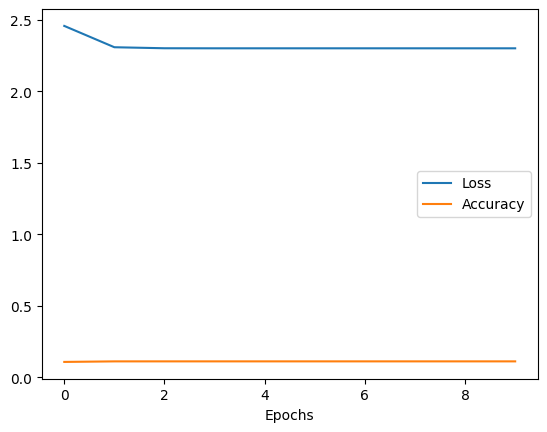

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(10),history.history['loss'],label = 'Loss')
plt.plot(range(10),history.history['accuracy'],label = 'Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

C:\Users\51man\AppData\Local\Temp\ipykernel_18492\3376422538.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


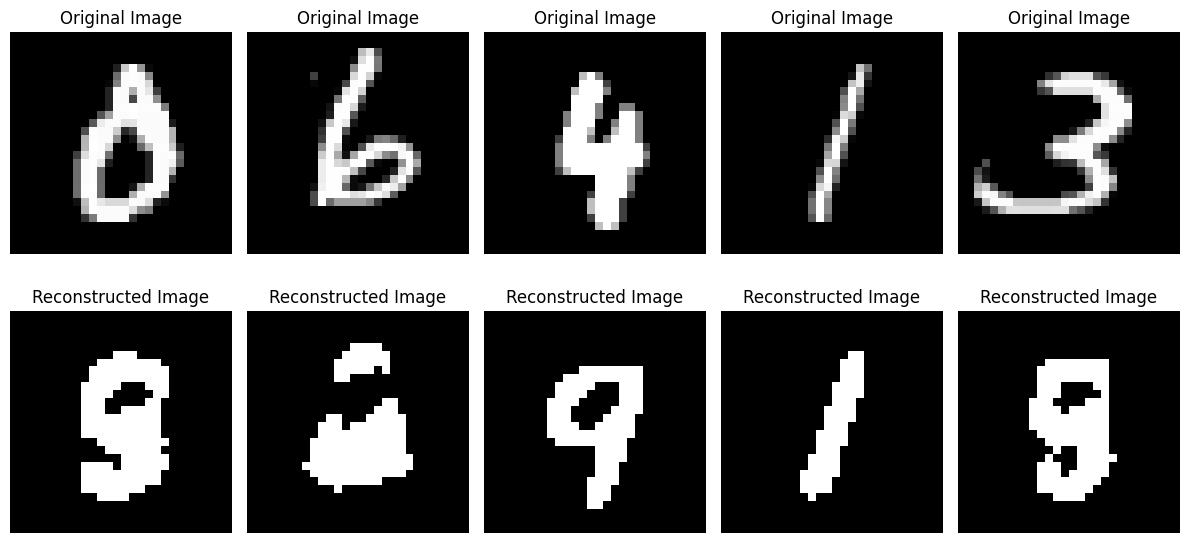

In [10]:
import matplotlib.pyplot as plt

sample_indices = [i for i in range(5)] 

plt.figure(figsize=(12, 6))
num_samples = len(sample_indices)

for i, idx in enumerate(sample_indices, 1):

    plt.subplot(2, num_samples, i)
    plt.imshow(train_images[idx].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    reconstructed_data = dbn.reconstruct(dbn.transform(train_images[idx][None]))[0]

    plt.subplot(2, num_samples, num_samples + i)
    plt.imshow(reconstructed_data.reshape(28, 28), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

plt.tight_layout()
plt.show()
